<h1>Emotion Classification on Twitter Messages</h1>

In [1]:
##libraries used in this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import pickle
import os
import random
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
import warnings
warnings.filterwarnings('ignore')

In [2]:
##reading the csv file which has the text and labels
data = pd.read_csv('text.csv')

In [3]:
##shows top 5 rows
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [4]:
##deleting the extra index column
del data['Unnamed: 0']

In [5]:
##shows top 5 rows
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [6]:
##shows bottom 5 rows
data.tail()

,text,label
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3
416808,i think that after i had spent some time inves...,5


In [7]:
##shows the number of rows and columns in the dataset
data.shape

(416809, 2)

In [8]:
##show us the data types of the columns
data.dtypes

text     object
label     int64
dtype: object

In [9]:
##shows the information of the dataset like non-null values, data types.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [10]:
##show us the number of duplicate rows in the dataset
print(data.duplicated().sum())

686


In [11]:
##drop the duplicates
data.drop_duplicates(inplace=True)

In [12]:
##shows number of rows and columns
data.shape

(416123, 2)

In [13]:
##shows the total number of null values in each column
data.isnull().sum()

text     0
label    0
dtype: int64

In [14]:
##map from numbers to emotion labels
emotion_labels = {
    0: 'Sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

In [15]:
##created new column of emotion labels
data['emotion_label'] = data['label'].map(emotion_labels)

In [16]:
##shows top 5 rows
data.head()

,text,label,emotion_label
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,Sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,Sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


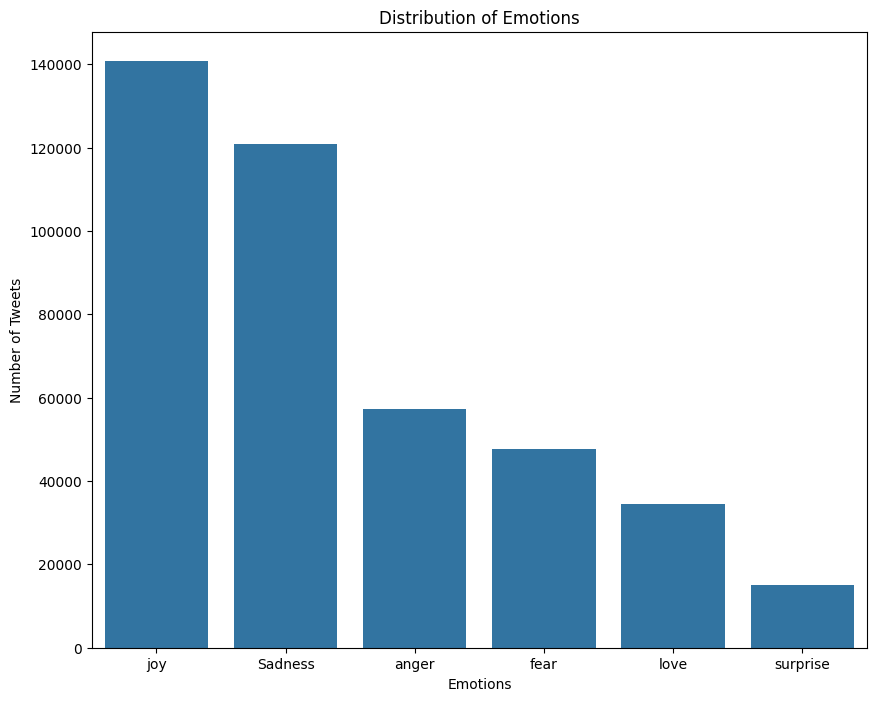

In [17]:
##shows distribution of emotions
plt.figure(figsize=(10, 8))
sns.countplot(x='emotion_label', data=data, order=data['emotion_label'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Number of Tweets')
plt.show()

In [18]:
##shows the counts of each emotion label
data['emotion_label'].value_counts()

emotion_label
joy         140779
Sadness     120989
anger        57235
fear         47664
love         34497
surprise     14959
Name: count, dtype: int64

In [19]:
data['message_length'] = data['text'].astype(str).apply(len)

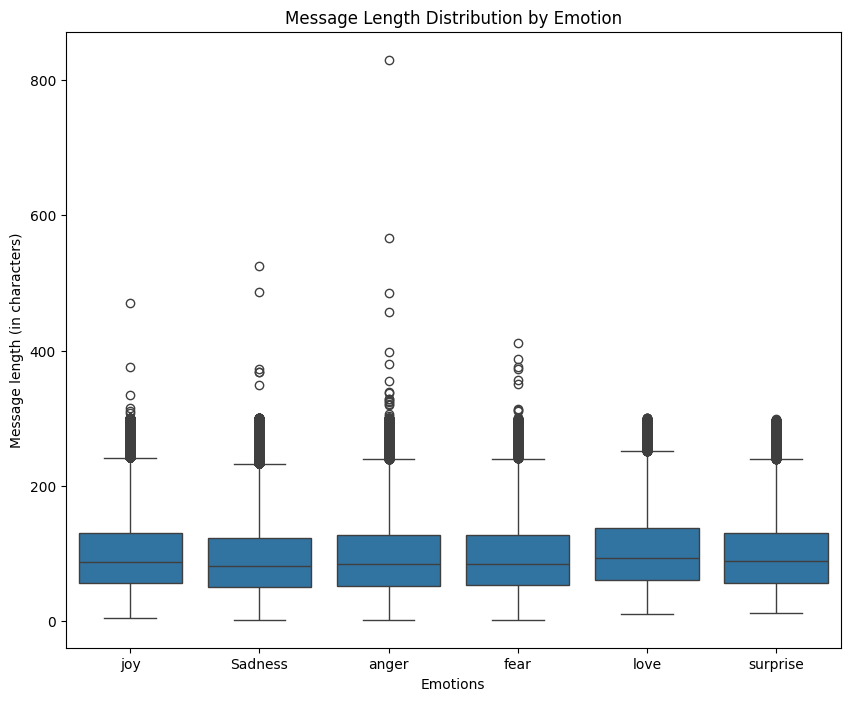

In [20]:
##shows distribution of emotions
plt.figure(figsize=(10, 8))
sns.boxplot(x='emotion_label', y='message_length', data=data, order=data['emotion_label'].value_counts().index)
plt.title('Message Length Distribution by Emotion')
plt.xlabel('Emotions')
plt.ylabel('Message length (in characters)')
plt.show()

In [21]:
data['message_length'].describe()

count    416123.000000
mean         97.102662
std          56.176302
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: message_length, dtype: float64

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
negative_words = {
    'not', 'no', 'nor', 'ain', 'aren', 'aren\'t', 'couldn', 'couldn\'t',
    'didn', 'didn\'t', 'doesn', 'doesn\'t', 'hadn', 'hadn\'t', 'hasn',
    'hasn\'t', 'haven', 'haven\'t', 'isn', 'isn\'t', 'mightn', 'mightn\'t',
    'mustn', 'mustn\'t', 'needn', 'needn\'t', 'shan', 'shan\'t', 'shouldn',
    'shouldn\'t', 'wasn', 'wasn\'t', 'weren', 'weren\'t', 'won', 'won\'t',
    'wouldn', 'wouldn\'t'
}

In [24]:
non_neg_stopwords = stop_words - negative_words

In [25]:
def get_pos(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [26]:
lemmatizer = WordNetLemmatizer()

In [27]:
def preprocessing_messages(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens_with_tag = pos_tag(tokens)
    words = []
    for word, tag in tokens_with_tag:
        if word not in non_neg_stopwords and len(word) > 1:
            pos = get_pos(tag)
            lemma = lemmatizer.lemmatize(word, pos=pos)
            words.append(lemma)
    return ' '.join(words)

In [28]:
data['cleaned_messages'] = data['text'].apply(preprocessing_messages)

In [29]:
data.head()

,text,label,emotion_label,message_length,cleaned_messages
0,i just feel really helpless and heavy hearted,4,fear,45,feel really helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,Sadness,234,ive enjoy able slouch relax unwind frankly nee...
2,i gave up my internship with the dmrg and am f...,4,fear,63,give internship dmrg feel distraught
3,i dont know i feel so lost,0,Sadness,26,dont know feel lose
4,i am a kindergarten teacher and i am thoroughl...,4,fear,222,kindergarten teacher thoroughly weary job take...


In [30]:
data['cleaned_message_length'] = data['cleaned_messages'].astype(str).apply(len)

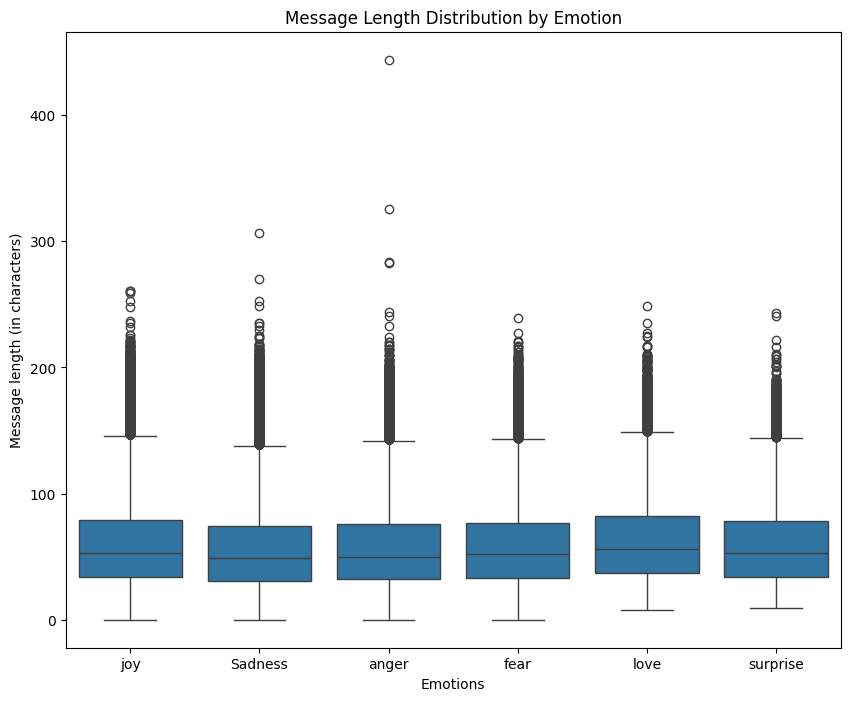

In [31]:
##shows distribution of emotions
plt.figure(figsize=(10, 8))
sns.boxplot(x='emotion_label', y='cleaned_message_length', data=data, order=data['emotion_label'].value_counts().index)
plt.title('Message Length Distribution by Emotion')
plt.xlabel('Emotions')
plt.ylabel('Message length (in characters)')
plt.show()

In [32]:
X = data['cleaned_messages']
y = data['label']

In [33]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

In [34]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=20, stratify=y_val_test)

In [35]:
X_train.shape

(291286,)

In [36]:
X_val.shape

(62418,)

In [37]:
X_test.shape

(62419,)

In [38]:
tfidf = TfidfVectorizer()

In [39]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [40]:
X_train_tfidf.shape

(291286, 54325)

In [41]:
X_val_tfidf.shape

(62418, 54325)

In [42]:
X_test_tfidf.shape

(62419, 54325)

In [43]:
model_nb = MultinomialNB()

In [44]:
model_nb.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [45]:
y_pred_nb = model_nb.predict(X_val_tfidf)

In [46]:
accuracy_score(y_val, y_pred_nb)

0.7605658624114838

In [47]:
print(classification_report(y_val, y_pred_nb))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84     18148
           1       0.70      0.97      0.81     21117
           2       0.96      0.22      0.36      5175
           3       0.93      0.61      0.74      8585
           4       0.90      0.49      0.63      7149
           5       0.97      0.07      0.12      2244

    accuracy                           0.76     62418
   macro avg       0.87      0.55      0.58     62418
weighted avg       0.80      0.76      0.73     62418



In [48]:
cm = confusion_matrix(y_val, y_pred_nb)

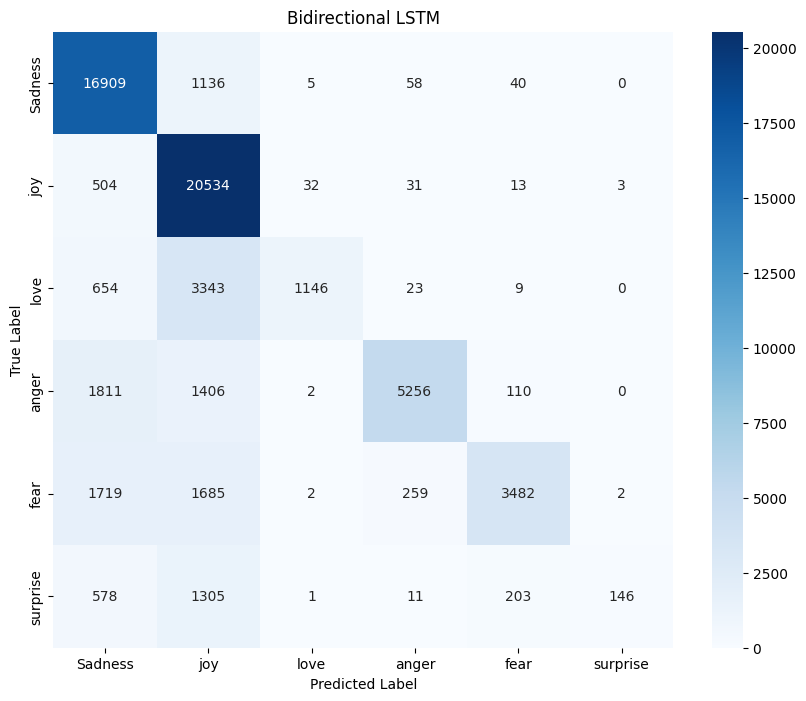

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Bidirectional LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [50]:
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')

In [51]:
model_lr.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [52]:
y_pred_lr = model_lr.predict(X_val_tfidf)

In [53]:
accuracy_score(y_val, y_pred_lr)

0.887420295427601

In [54]:
print(classification_report(y_val, y_pred_lr))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     18148
           1       0.96      0.87      0.91     21117
           2       0.71      0.91      0.80      5175
           3       0.87      0.92      0.89      8585
           4       0.83      0.85      0.84      7149
           5       0.64      0.91      0.75      2244

    accuracy                           0.89     62418
   macro avg       0.83      0.89      0.85     62418
weighted avg       0.90      0.89      0.89     62418



In [55]:
cm = confusion_matrix(y_val, y_pred_lr)

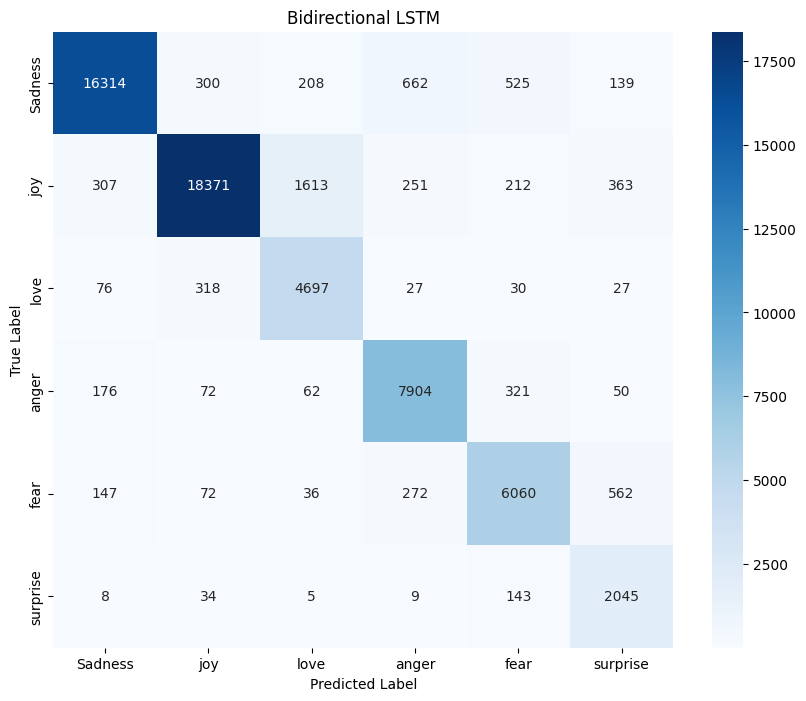

In [56]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Bidirectional LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [57]:
model_svc = LinearSVC(class_weight='balanced', max_iter=1000)

In [58]:
model_svc.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


In [59]:
y_pred_svc = model_svc.predict(X_val_tfidf)

In [60]:
accuracy_score(y_val, y_pred_svc)

0.8856579832740555

In [61]:
print(classification_report(y_val, y_pred_svc))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     18148
           1       0.93      0.89      0.91     21117
           2       0.73      0.83      0.77      5175
           3       0.88      0.91      0.89      8585
           4       0.83      0.84      0.83      7149
           5       0.66      0.82      0.73      2244

    accuracy                           0.89     62418
   macro avg       0.83      0.87      0.85     62418
weighted avg       0.89      0.89      0.89     62418



In [62]:
cm = confusion_matrix(y_val, y_pred_svc)

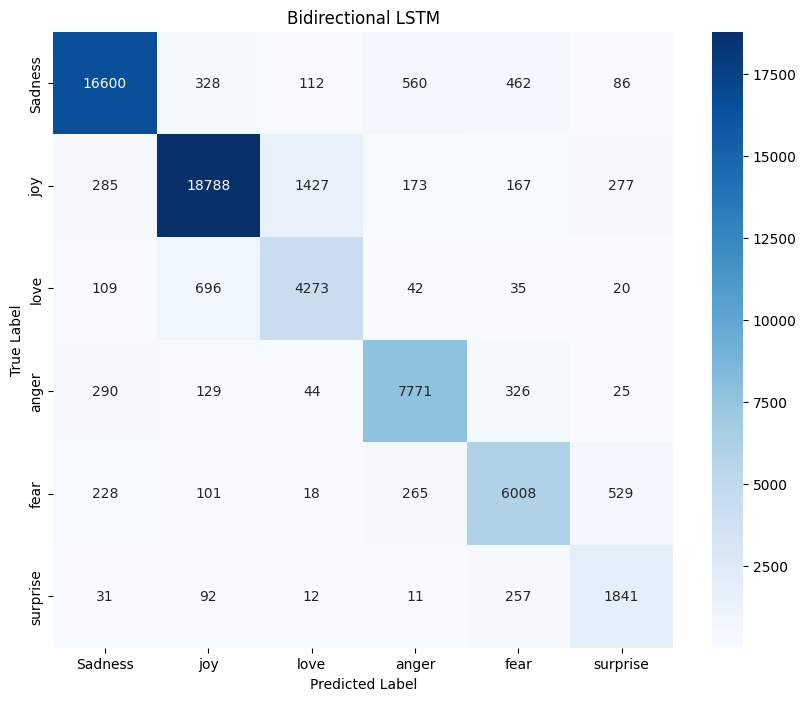

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Bidirectional LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [64]:
def preprocessing_messages_rnn(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [65]:
data['messages_rnn'] = data['text'].apply(preprocessing_messages_rnn)

In [66]:
data.head()

,text,label,emotion_label,message_length,cleaned_messages,cleaned_message_length,messages_rnn
0,i just feel really helpless and heavy hearted,4,fear,45,feel really helpless heavy hearted,34,i just feel really helpless and heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,Sadness,234,ive enjoy able slouch relax unwind frankly nee...,137,ive enjoyed being able to slouch about relax a...
2,i gave up my internship with the dmrg and am f...,4,fear,63,give internship dmrg feel distraught,36,i gave up my internship with the dmrg and am f...
3,i dont know i feel so lost,0,Sadness,26,dont know feel lose,19,i dont know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...,4,fear,222,kindergarten teacher thoroughly weary job take...,129,i am a kindergarten teacher and i am thoroughl...


In [67]:
X_rnn = data['messages_rnn']
y_rnn = data['label']

In [68]:
X_train_rnn = X_rnn[X_train.index]
y_train_rnn = y_rnn[y_train.index]

In [69]:
X_val_rnn = X_rnn[X_val.index]
y_val_rnn = y_rnn[y_val.index]

In [70]:
X_test_rnn = X_rnn[X_test.index]
y_test_rnn = y_rnn[y_test.index]

In [71]:
vocabulary_size = 15000
max_length = 100
embedding_dimen = 128

In [72]:
tokenizer = Tokenizer(num_words=vocabulary_size, oov_token='<OOV>')

In [73]:
tokenizer.fit_on_texts(X_train_rnn)

In [74]:
X_train_padd = pad_sequences(tokenizer.texts_to_sequences(X_train_rnn), maxlen=max_length, padding='post')
X_val_padd = pad_sequences(tokenizer.texts_to_sequences(X_val_rnn), maxlen=max_length, padding='post')
X_test_padd = pad_sequences(tokenizer.texts_to_sequences(X_test_rnn), maxlen=max_length, padding='post')

In [75]:
class_wt_arr = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_rnn), y=y_train_rnn)

In [76]:
class_weights = {i: class_wt_arr[i] for i in range(len(class_wt_arr))}

In [77]:
class_weights

{0: np.float64(0.5732261213180309),
 1: np.float64(0.4926446462698936),
 2: np.float64(2.0104218430787917),
 3: np.float64(1.21172261741337),
 4: np.float64(1.4550477046805534),
 5: np.float64(4.636392576321905)}

In [78]:
model_simple_rnn = Sequential([
    Embedding(vocabulary_size, embedding_dimen, input_length=max_length),
    SimpleRNN(64, dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [79]:
model_simple_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [80]:
model_simple_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [81]:
history_simple_rnn = model_simple_rnn.fit(
    X_train_padd,
    y_train_rnn,
    epochs=5,
    validation_data=(X_val_padd, y_val_rnn),
    class_weight=class_weights,
    batch_size=128,
    verbose=2
)

Epoch 1/5
2276/2276 - 63s - 28ms/step - accuracy: 0.1953 - loss: 1.7925 - val_accuracy: 0.1375 - val_loss: 1.7904
Epoch 2/5
2276/2276 - 62s - 27ms/step - accuracy: 0.1720 - loss: 1.7918 - val_accuracy: 0.1375 - val_loss: 1.7911
Epoch 3/5
2276/2276 - 62s - 27ms/step - accuracy: 0.1698 - loss: 1.7919 - val_accuracy: 0.1375 - val_loss: 1.7911
Epoch 4/5
2276/2276 - 64s - 28ms/step - accuracy: 0.1668 - loss: 1.7920 - val_accuracy: 0.1375 - val_loss: 1.7911
Epoch 5/5
2276/2276 - 65s - 28ms/step - accuracy: 0.1698 - loss: 1.7918 - val_accuracy: 0.1375 - val_loss: 1.7911


In [82]:
model_lstm = Sequential([
    Embedding(vocabulary_size, embedding_dimen, input_length=max_length),
    LSTM(64, dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [83]:
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [84]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [85]:
history_lstm = model_lstm.fit(
    X_train_padd,
    y_train_rnn,
    epochs=5,
    validation_data=(X_val_padd, y_val_rnn),
    class_weight=class_weights,
    batch_size=128,
    verbose=2
)

Epoch 1/5
2276/2276 - 140s - 62ms/step - accuracy: 0.1615 - loss: 1.7920 - val_accuracy: 0.1375 - val_loss: 1.7911
Epoch 2/5
2276/2276 - 135s - 59ms/step - accuracy: 0.1697 - loss: 1.7918 - val_accuracy: 0.1375 - val_loss: 1.7911
Epoch 3/5
2276/2276 - 126s - 55ms/step - accuracy: 0.1698 - loss: 1.7918 - val_accuracy: 0.1375 - val_loss: 1.7911
Epoch 4/5
2276/2276 - 133s - 58ms/step - accuracy: 0.1698 - loss: 1.7918 - val_accuracy: 0.1375 - val_loss: 1.7911
Epoch 5/5
2276/2276 - 130s - 57ms/step - accuracy: 0.1555 - loss: 1.7919 - val_accuracy: 0.1375 - val_loss: 1.7911


In [86]:
model_bi_lstm = Sequential([
    Embedding(vocabulary_size, embedding_dimen, input_length=max_length),
    Bidirectional(LSTM(64, dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [87]:
model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [88]:
model_bi_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [89]:
history_bi_lstm = model_bi_lstm.fit(
    X_train_padd,
    y_train_rnn,
    epochs=5,
    validation_data=(X_val_padd, y_val_rnn),
    class_weight=class_weights,
    batch_size=128,
    verbose=2
)

Epoch 1/5
2276/2276 - 231s - 101ms/step - accuracy: 0.8520 - loss: 0.3610 - val_accuracy: 0.9212 - val_loss: 0.1638
Epoch 2/5
2276/2276 - 237s - 104ms/step - accuracy: 0.9267 - loss: 0.1462 - val_accuracy: 0.9285 - val_loss: 0.1434
Epoch 3/5
2276/2276 - 238s - 104ms/step - accuracy: 0.9349 - loss: 0.1229 - val_accuracy: 0.9356 - val_loss: 0.1286
Epoch 4/5
2276/2276 - 270s - 119ms/step - accuracy: 0.9380 - loss: 0.1148 - val_accuracy: 0.9375 - val_loss: 0.1275
Epoch 5/5
2276/2276 - 225s - 99ms/step - accuracy: 0.9394 - loss: 0.1106 - val_accuracy: 0.9387 - val_loss: 0.1211


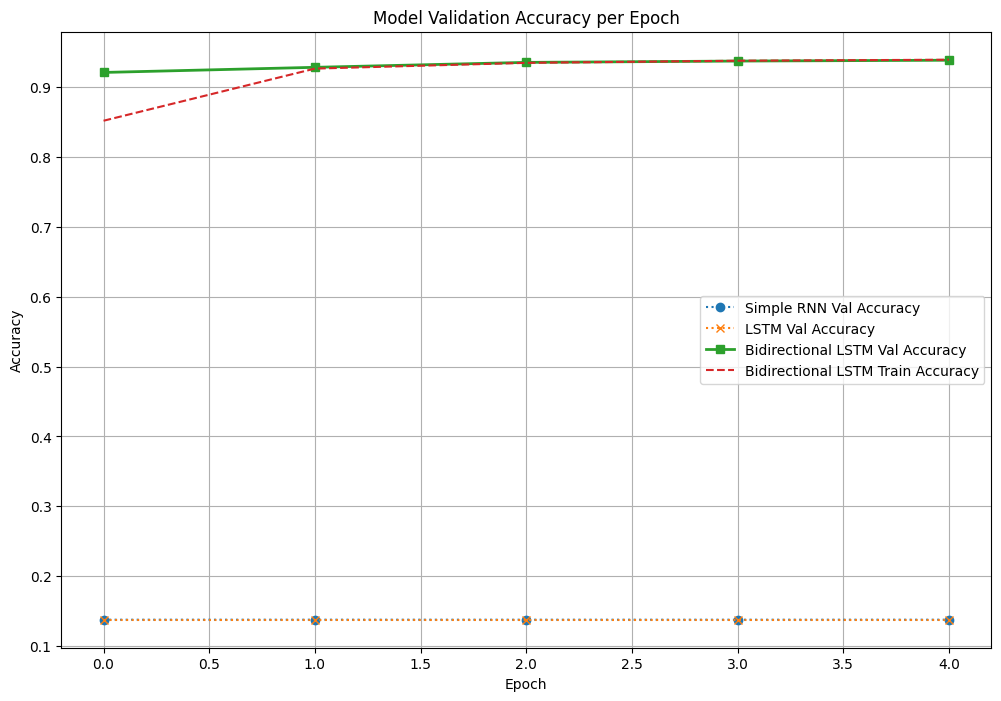

In [90]:
plt.figure(figsize=(12, 8))
plt.plot(history_simple_rnn.history['val_accuracy'], label='Simple RNN Val Accuracy', marker='o', linestyle=':')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Accuracy', marker='x', linestyle=':')
plt.plot(history_bi_lstm.history['val_accuracy'], label='Bidirectional LSTM Val Accuracy', marker='s', linewidth=2)
plt.plot(history_bi_lstm.history['accuracy'], label='Bidirectional LSTM Train Accuracy', linestyle='--')
plt.title('Model Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [91]:
y_pred_test_probs = model_bi_lstm.predict(X_test_padd)
y_pred_test = np.argmax(y_pred_test_probs, axis=1)

1951/1951 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step


In [92]:
accuracy_score(y_test_rnn, y_pred_test)

0.9367820695621526

In [93]:
print(classification_report(y_test_rnn, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     18149
           1       1.00      0.91      0.95     21117
           2       0.77      1.00      0.87      5174
           3       0.91      0.98      0.94      8585
           4       0.92      0.87      0.89      7150
           5       0.71      0.99      0.83      2244

    accuracy                           0.94     62419
   macro avg       0.88      0.95      0.91     62419
weighted avg       0.95      0.94      0.94     62419



In [94]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
model_bi_lstm.save('emotion_model.keras')

In [96]:
cm = confusion_matrix(y_test_rnn, y_pred_test)

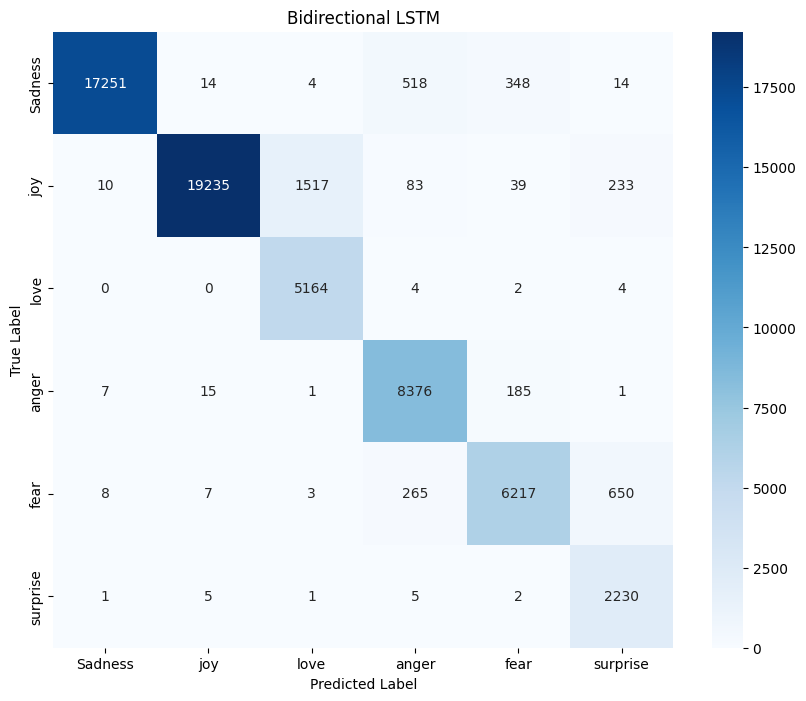

In [97]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Bidirectional LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [98]:
accuracies = {
    'MultinomialNB': accuracy_score(y_val, y_pred_nb),
    'LogisticRegression': accuracy_score(y_val, y_pred_lr),
    'LinearSVC': accuracy_score(y_val, y_pred_svc),
    'Bidirectional LSTM': max(history_bi_lstm.history['val_accuracy'])
}

In [99]:
accuracies_series = pd.Series(accuracies)

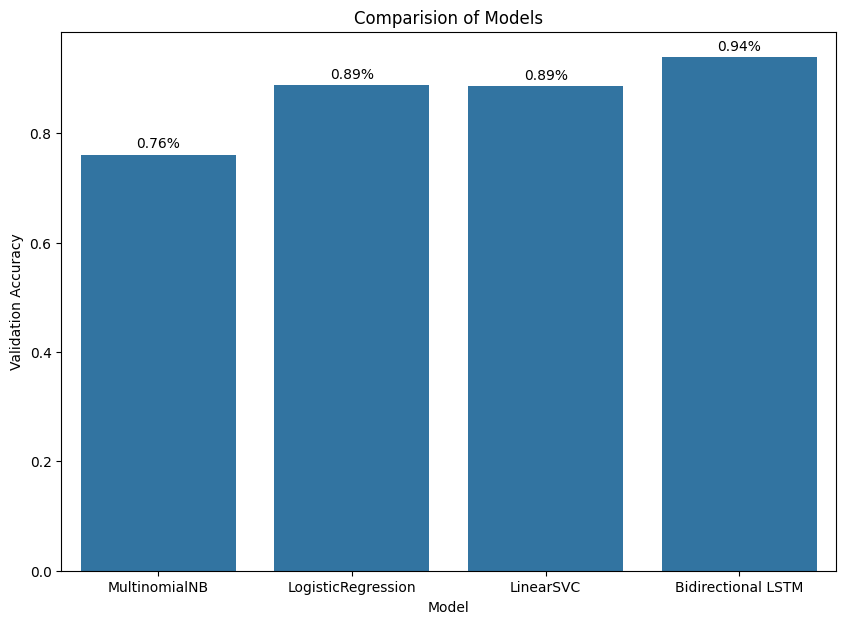

In [100]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=accuracies_series.index, y=accuracies_series.values)
ax.bar_label(ax.containers[0], fmt='%.2f%%', padding=3)
plt.ylabel('Validation Accuracy')
plt.xlabel('Model')
plt.title('Comparision of Models')
plt.show()

In [101]:
error_analysis = pd.DataFrame({
    'message': X_test_rnn,
    'true label': y_test_rnn,
    'predicted label': y_pred_test
})

In [102]:
error_analysis['true emotion'] = error_analysis['true label'].map(emotion_labels)

In [103]:
error_analysis['predicted emotion'] = error_analysis['predicted label'].map(emotion_labels)

In [104]:
error_analysis.head()

,message,true label,predicted label,true emotion,predicted emotion
92456,i was feeling creative a href http littlestron...,1,1,joy,joy
271228,i had gone home and told my sister everything ...,2,2,love,love
229484,i feel more and more bitter against serena aft...,3,3,anger,anger
400800,im feeling stressed and didnt have time to tak...,3,3,anger,anger
163878,i guess i have been feeling a little defeated,0,0,Sadness,Sadness


In [105]:
errors = error_analysis[error_analysis['true label'] != error_analysis['predicted label']]

In [106]:
errors.head()

,message,true label,predicted label,true emotion,predicted emotion
11639,im feeling generous about myself and it sounds...,1,2,joy,love
42874,i remember feeling helpless and angry and frus...,0,4,Sadness,fear
287902,im not feeling generous,1,2,joy,love
47071,i perceive you feel the dint of pity these are...,1,2,joy,love
124494,passing my drivers examination after two failures,1,4,joy,fear


In [107]:
len(errors)

3946

In [108]:
len(X_test_rnn)

62419

In [109]:
errors.sample(10, random_state=seed_value)

,message,true label,predicted label,true emotion,predicted emotion
276080,i will feel extremely agitated and sad,4,3,fear,anger
353393,i really do feel blessed beyond measure lately,1,2,joy,love
283605,i am feeling generous to you all today,1,2,joy,love
311757,i can feel wolf and my beloved parents,1,2,joy,love
196716,ill probably not do it like im sure some of th...,1,2,joy,love
152611,i feel overwhelmed or not prepared the enjoyme...,4,5,fear,surprise
206027,when i think about my parents getting old,0,3,Sadness,anger
35327,i just feel like posting up what happen during...,1,2,joy,love
59315,i have a feeling the blacksburg faithful are g...,1,2,joy,love
293241,i know what it is like to feel hated to be mis...,0,3,Sadness,anger


In [110]:
errors.groupby(['true emotion', 'predicted emotion']).size().sort_values(ascending=False)

true emotion  predicted emotion
joy           love                 1517
fear          surprise              650
Sadness       anger                 518
              fear                  348
fear          anger                 265
joy           surprise              233
anger         fear                  185
joy           anger                  83
              fear                   39
anger         joy                    15
Sadness       surprise               14
              joy                    14
joy           Sadness                10
fear          Sadness                 8
              joy                     7
anger         Sadness                 7
surprise      joy                     5
              anger                   5
love          anger                   4
              surprise                4
Sadness       love                    4
fear          love                    3
love          fear                    2
surprise      fear                    2
        

In [111]:
pd.set_option('display.max_colwidth', None)
errors[(errors['true emotion'] == 'joy') & (errors['predicted emotion'] == 'love')].head(5)

,message,true label,predicted label,true emotion,predicted emotion
11639,im feeling generous about myself and it sounds better,1,2,joy,love
287902,im not feeling generous,1,2,joy,love
47071,i perceive you feel the dint of pity these are gracious drops,1,2,joy,love
152735,i come from and how much i feel blessed on a daily basis for the strong environment that i grew up in,1,2,joy,love
373084,i feel passionate about sharing not a dogma but an acausal logic anyway mainly i do my best to focus on it purely as a personal exercise expression and enjoyment,1,2,joy,love
